In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from bandit import *

In [22]:
num_actions = 10
num_worlds = 2000
steps_per_world = 1000

agent_creators = [
    lambda: RandomAgent(num_actions),
    lambda: GreedyAgent(num_actions),
    lambda: GreedyAgent(num_actions, initial_estimate=5),
    lambda: EGreedyAgent(num_actions, eps=0.5),
    lambda: EGreedyAgent(num_actions, eps=0.01),
    lambda: EGreedyAgent(num_actions, eps=0.1),
]

create_world = lambda i: World(i, num_actions)

In [23]:
args = [
    (create_agent(), agent_id, create_world(world_id), world_id, steps_per_world)
    for world_id in range(num_worlds)
    for agent_id, create_agent in enumerate(agent_creators)
]
with Pool(20) as pool:
    results = pool.starmap(run_experiment, args)

aggregated_result = np.stack(results, axis=2)
aggregated_result.shape

(1000, 4, 12000)

In [24]:
a = np.sum(aggregated_result, axis=0)
aggregated_by_world = a.reshape(a.shape[0], num_worlds, len(agent_creators))
aggregated_by_world.shape

(4, 2000, 6)

In [25]:
agent_id_to_name = [create_agent().name for create_agent in agent_creators]

In [26]:
import matplotlib.pyplot as plt

width = 20
height = 13

def get_figure(width=width, height=height):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    
    return fig, ax

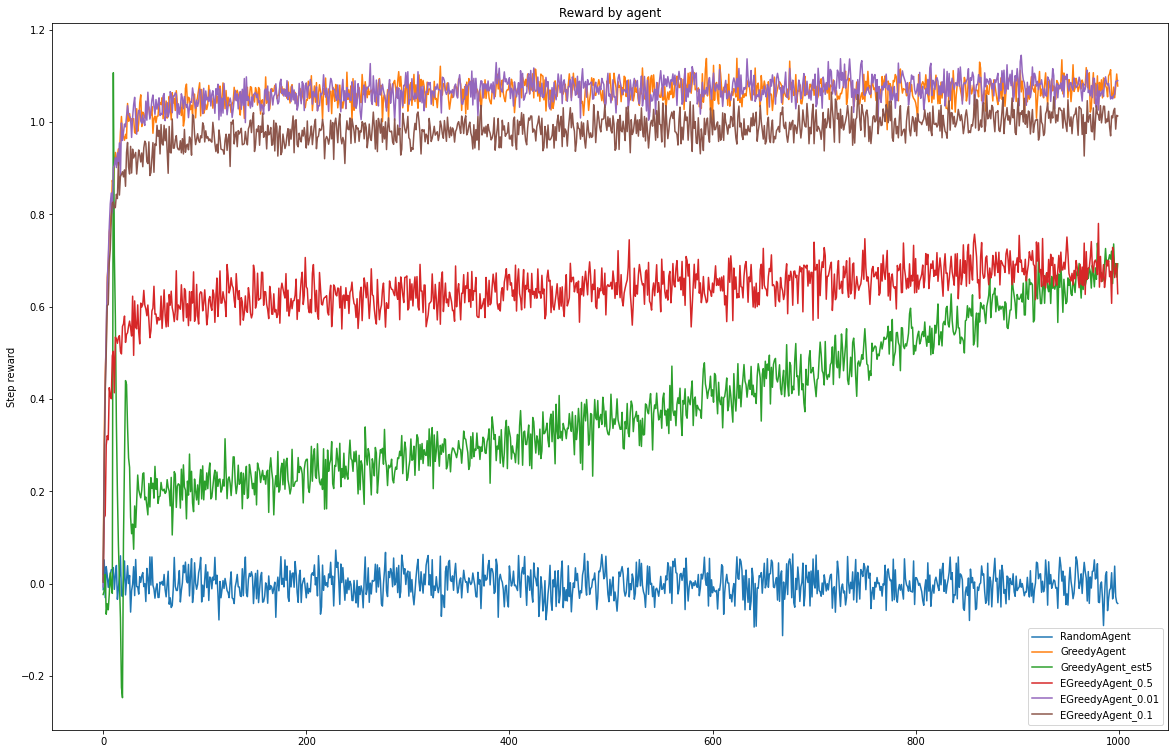

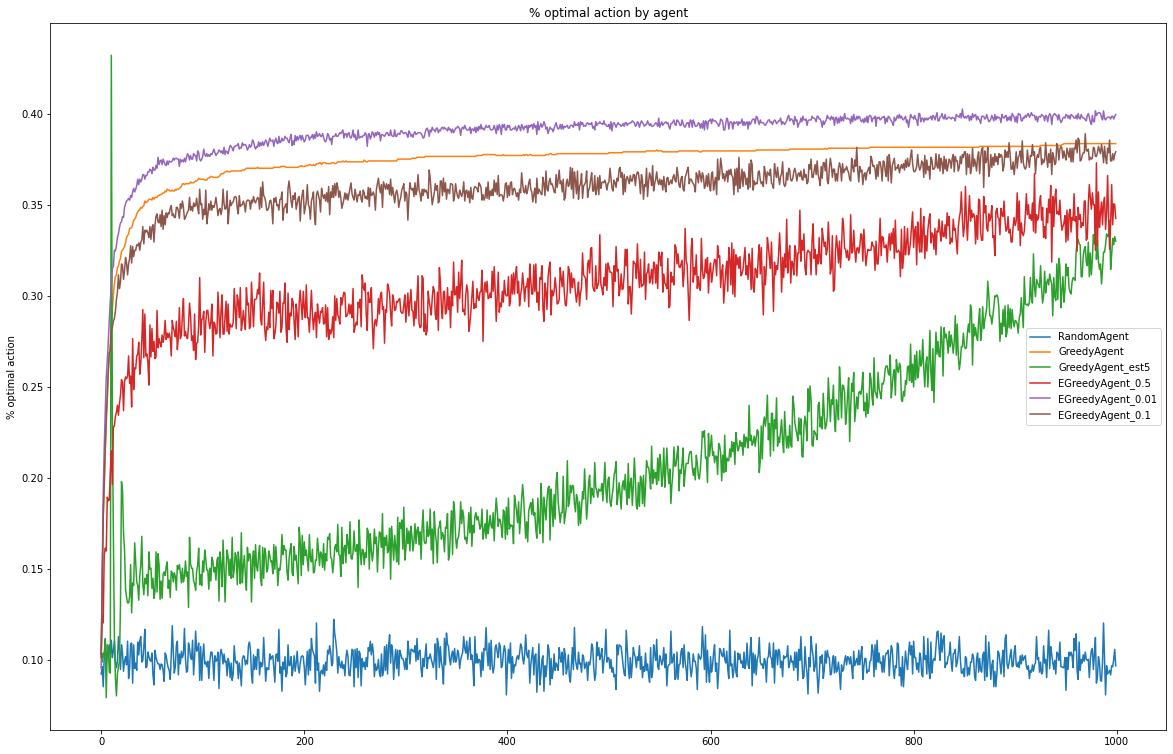

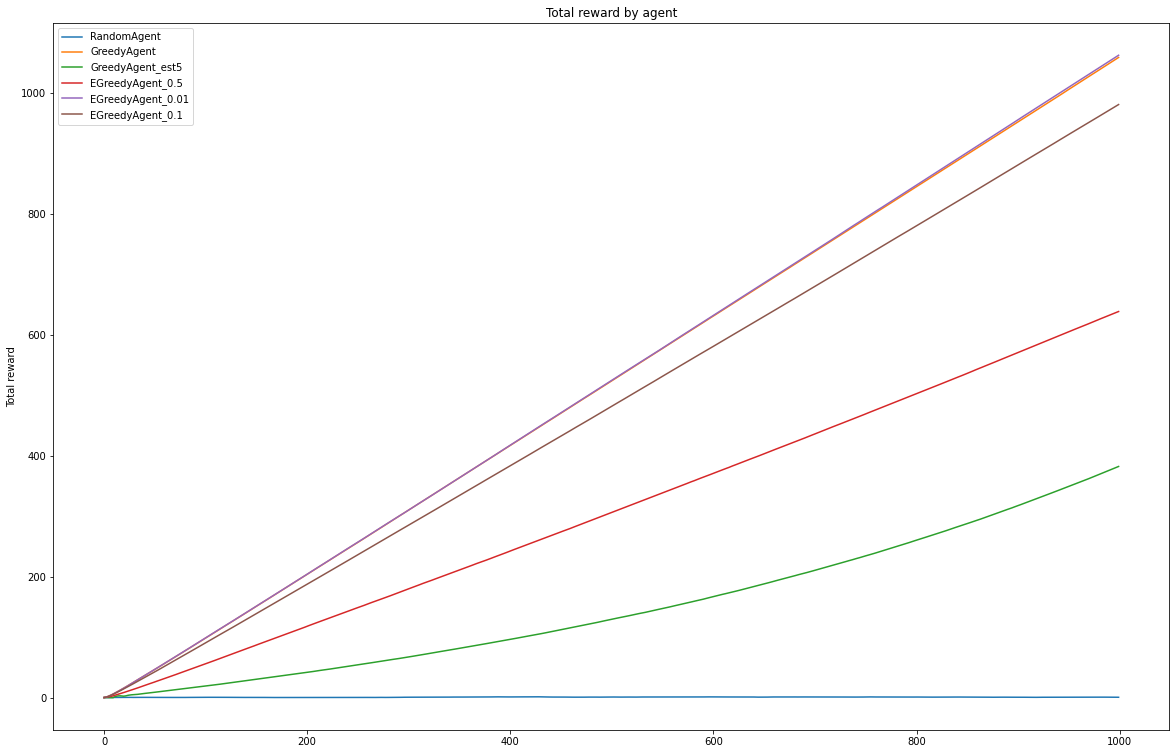

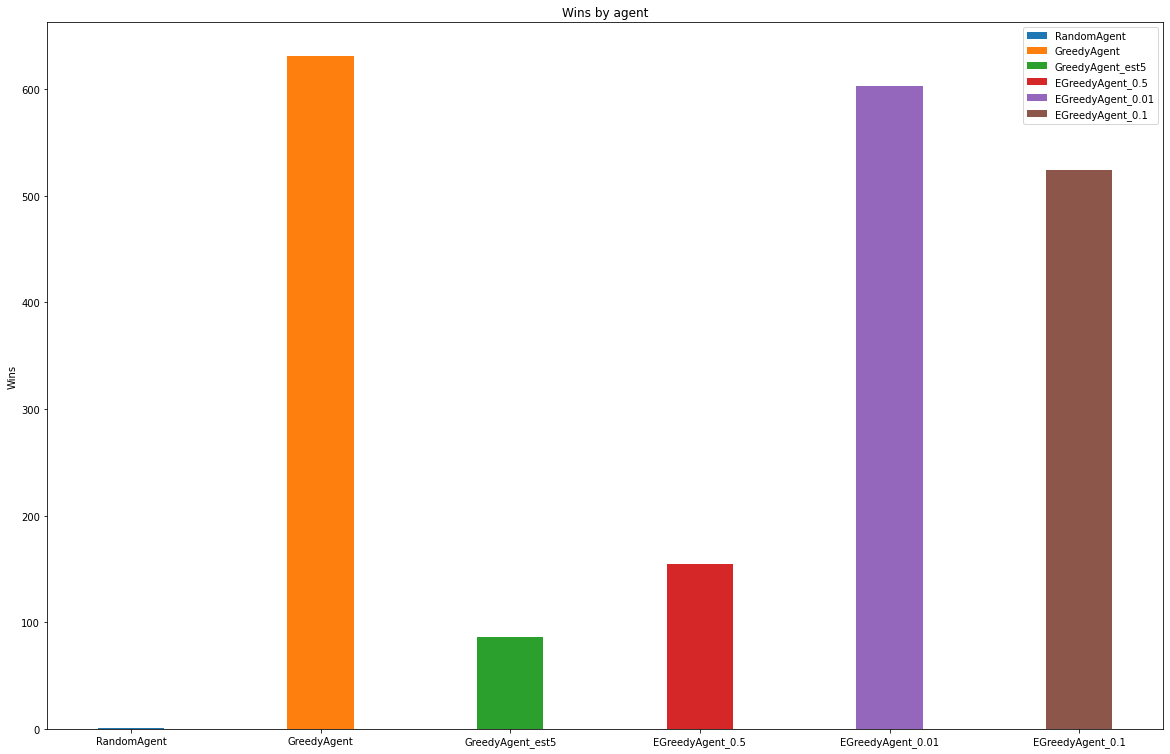

In [27]:
fig1, ax1 = get_figure()
fig2, ax2 = get_figure()
fig3, ax3 = get_figure()
fig4, ax4 = get_figure()

unique, counts = np.unique(np.argmax(aggregated_by_world[2], axis=1), return_counts=True)
index_to_wins = {index: count for index, count in zip(unique, counts)}

bar_width = 0.35

num_agents = len(agent_creators)
for agent_id in range(num_agents):
    agent_results = np.mean(aggregated_result[:, :, agent_id::num_agents], axis=2)
    
    label = agent_id_to_name[agent_id]
    
    ax1.plot(agent_results[:,2], label=label)
    ax2.plot(agent_results[:,3], label=label)
    ax3.plot(np.cumsum(agent_results[:,2]), label=label)
    
    wins = index_to_wins.get(agent_id, 0)
    ax4.bar([label], wins, bar_width, label=label)

        
ax1.set_ylabel('Step reward')
ax1.set_title('Reward by agent')
ax1.legend()

ax2.set_ylabel('% optimal action')
ax2.set_title('% optimal action by agent')
ax2.legend()

ax3.set_ylabel('Total reward')
ax3.set_title('Total reward by agent')
ax3.legend()

ax4.set_ylabel('Wins')
ax4.set_title('Wins by agent')
ax4.legend()

plt.show()